# **AIN 214 - PA4 - FALL 2024**




**Student Number** :2230765034

**Name Surname**   :Şeyma Doğan


BELOW MD CELLS CONTAIN THE QUESTIONS YOU ARE ASKED TO IMPLEMENT WITHIN THE CONTEXT OF THIS HW. PLEASE FILL IN THE CELLS FOR THE ANSWERS RIGHT BELOW THE MD CELL OF THE QUESTION. YOU CAN ADD AS MANY CELLS AS YOU WANT, BE IT CODE OR MD, SO LONG AS YOU PROVIDE UNDERSTANDABLE AND TRACEABLE REPORTING. PLEASE ADD COMMENTS ON YOUR CODES. ALSO, FILL IN MD CELLS WHERE YOU ARE ASKED TO COMMENT ON YOUR RESULTS OR EXPLAIN YOUR REASONING. ALSO, PLEASE DO NOT HESITATE TO USE THEM FOR YOUR OWN REPORTING PURPOSES. PLEASE KEEP IN MIND THAT, REPORTING IS A KEY STEP IN DATA SCIENCE.

**Deadline: 13.12.2024 (23:59:59)**

**Submission:** Submit your Jupyter Notebooks via https://submit.cs.hacettepe.edu.tr/

<font color='red'> **!!! PLEASE RUN YOUR CODE.   THE OUTPUT OF YOUR CODE MUST BE VISIBLE. DO NOT DELETE OR HIDE THE OUTPUT.**</font>



---


# **Building kNN and Logistic Regression Classifiers**

---
**Dataset Path:** "Data/stroke.csv"
---

We will deal with the stroke dataset. The dataset contains demographic and health-related data to predict whether a patient is likely to have a stroke.

**Features:**


* id: Unique identifier (can be ignored for modeling).
* gender: Gender of the patient (categorical).
* age: Age of the patient (numerical).
* hypertension: Whether the patient has hypertension (0 = No, 1 = Yes).
* heart_disease: Whether the patient has heart disease (0 = No, 1 = Yes).
* ever_married: Marital status (categorical).
* work_type: Type of work (categorical).
* Residence_type: Rural or Urban (categorical).
* avg_glucose_level: Average glucose level (numerical).
* bmi: Body Mass Index (numerical).
* smoking_status: Smoking habits (categorical).
* stroke: Target variable (1 = Stroke, 0 = No Stroke).

In [1]:
# **Necessary Imports**
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression



# **PART- 1: Data Preprocessing and Visualization (35 Pts)**

---

## 1.1. Explaratory Data Analysis (20 Pts)

* Load the dataset
* Check and Handle Missing Values

  * Identify columns with missing values.
  * Replace missing values using suitable methods (mean or median imputation).

* Check and Handle Outliers

  * Detect outliers in numerical features
  * Handle outliers appropriately

* Convert categorical variables into numerical values.
* Perform data normalization



In [2]:
# Loads the dataset and checks for the missing values
df = pd.read_csv("Data/stroke.csv")

print(df.isnull().sum()) 
# As we can see 201 bmi values are missing. 

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


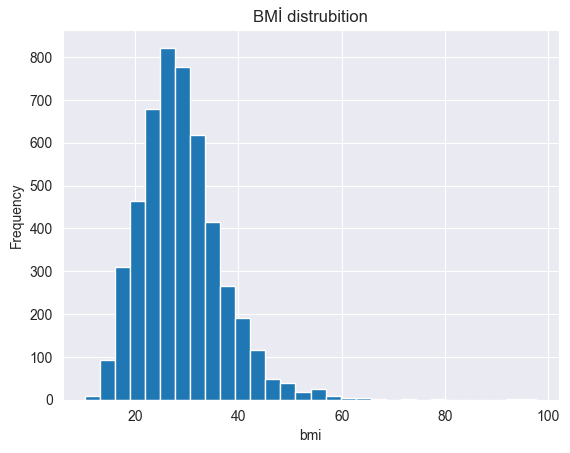

In [3]:
# Firstly there is a seable lost in the bmi values so ı need to visualize it.

plt.hist(df['bmi'], bins=30)
plt.xlabel('bmi')
plt.ylabel('Frequency')
plt.title('BMİ distrubition')
plt.show()


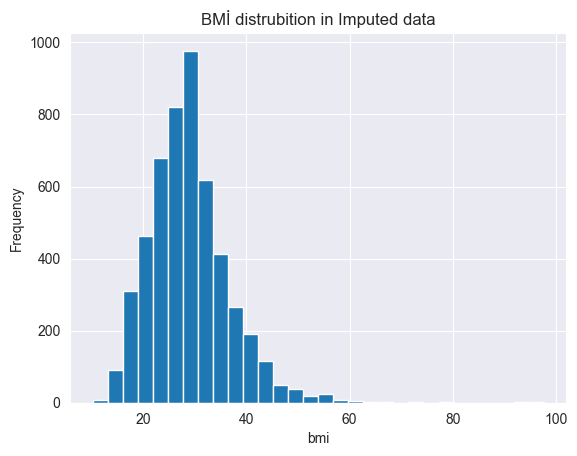

In [4]:
# Handle Missing Values
# For this kind of distrubition (skewed) we should prefer 'Median Imputation'
# As the median is less sensitive to outliers and a skewed disturbition; than the mean.

df_imputed = df.copy()
df_imputed['bmi'] = df_imputed['bmi'].fillna(df_imputed['bmi'].median())

# BMİ distrubition in Imputed data
plt.hist(df_imputed['bmi'], bins=30)
plt.xlabel('bmi')
plt.ylabel('Frequency')
plt.title('BMİ distrubition in Imputed data')
plt.show()

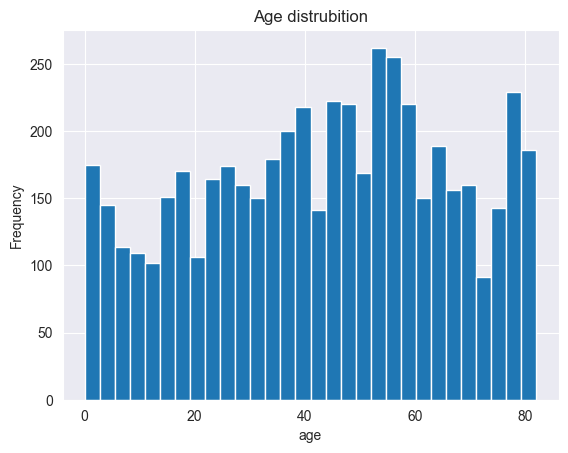

In [5]:
# Checking for the outiers in age column
plt.hist(df_imputed['age'], bins=30)
plt.xlabel('age')
plt.ylabel('Frequency')
plt.title('Age distrubition') 
plt.show()
# It has a pretty even disturbition, there isn't outliers.

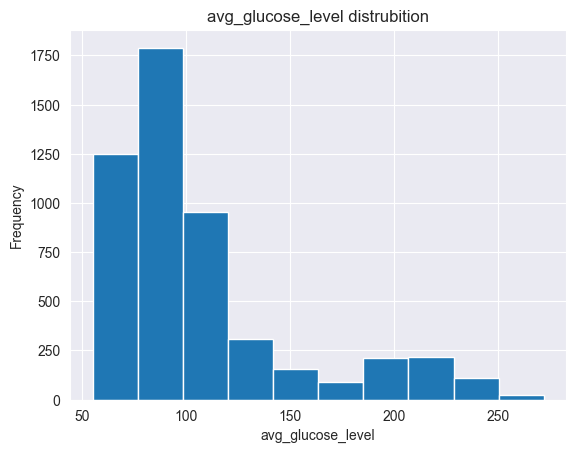

In [6]:
# Checking for the outiers in avg_glucose_level column
plt.hist(df_imputed['avg_glucose_level'], bins=10)
plt.xlabel('avg_glucose_level')
plt.ylabel('Frequency')
plt.title('avg_glucose_level distrubition') 
plt.show()

# As it can be seen from the graph it has a tail so it has outliers.

In [7]:
# Handling Outliers:

# We have an skewed disturbition so using Z-score would lead us to misleading conclusions. 
# So I will use IQR this time cause its more robust to outliers and skewed data than Z-score. 
# Also it's easy to implement too.
# Outliers == [< Q1 - 1.5*IQR] or [> Q3 + 1.5*IQR]

# Checks and Handles Outliers for age
df_IQR = df_imputed.copy()
sorted_age = np.sort(df_IQR['age']) 
Q1_age = np.percentile(sorted_age, 25, interpolation ='midpoint')
Q2_age = np.percentile(sorted_age, 50, interpolation = 'midpoint')
Q3_age = np.percentile(sorted_age, 75, interpolation = 'midpoint') 

IQR_age = Q3_age - Q1_age
low_lim_age = Q1_age - 1.5*IQR_age
up_lim_age = Q3_age + 1.5*IQR_age
print('low_limit_age is', low_lim_age)
print('up_limit_age is', up_lim_age)

outliers_age = []
count_outliers_age = 0
for x in sorted_age:
    if ((x < low_lim_age) or (x > up_lim_age)):
        outliers_age.append(x) 
print("There is ",count_outliers_age," outliers in the age data.")
# There is no outliers in the age data.


# Checks and Handles Outliers for bmi 
sorted_bmi = np.sort(df_IQR['bmi']) 
Q1_bmi = np.percentile(sorted_bmi, 25, interpolation ='midpoint')
Q2_bmi = np.percentile(sorted_bmi, 50, interpolation = 'midpoint')
Q3_bmi = np.percentile(sorted_bmi, 75, interpolation = 'midpoint') 

IQR_bmi = Q3_bmi - Q1_bmi
low_lim_bmi = Q1_bmi - 1.5*IQR_bmi
up_lim_bmi = Q3_bmi + 1.5*IQR_bmi
print('low_limit_bmi is', low_lim_bmi)
print('up_limit_bmi is', up_lim_bmi)

outliers_bmi = []
count_outliers_bmi = 0
for x in sorted_bmi:
    if ((x < low_lim_bmi) or (x > up_lim_bmi)):
        outliers_bmi.append(x)
        count_outliers_bmi += 1
print("There is ",count_outliers_bmi," outliers in the bmi data.") 
# There is  126  outliers in the bmi data.


# Checks and Handles Outliers for avg_glucose_level
sorted_avg_glu = np.sort(df_IQR['avg_glucose_level']) 
Q1_avg_glu = np.percentile(sorted_avg_glu, 25, interpolation ='midpoint')
Q2_avg_glu = np.percentile(sorted_avg_glu, 50, interpolation = 'midpoint')
Q3_avg_glu = np.percentile(sorted_avg_glu, 75, interpolation = 'midpoint') 

IQR_avg_glu = Q3_avg_glu - Q1_avg_glu
low_lim_avg_glu = Q1_avg_glu - 1.5*IQR_avg_glu
up_lim_avg_glu = Q3_avg_glu + 1.5*IQR_avg_glu
print('low_limit_avg_glucose_level is', low_lim_avg_glu)
print('up_limit_avg_glucose_level is', up_lim_avg_glu)

outliers_avg_glu = []
count_outliers_avg_glu = 0
for x in sorted_avg_glu:
    if ((x < low_lim_avg_glu) or (x > up_lim_avg_glu)):
        outliers_avg_glu.append(x)
        count_outliers_avg_glu += 1
print("There is ",count_outliers_avg_glu," outliers in the avg_glucose_level data.") 
# print(outliers_avg_glu)
# There is  627  outliers in the avg_glucose_level data.
# That's way too above %5 of the data so I will use a different way to detect outliers.

low_limit_age is -29.0
up_limit_age is 115.0
There is  0  outliers in the age data.
low_limit_bmi is 10.300000000000006
up_limit_bmi is 46.29999999999999
There is  126  outliers in the bmi data.
low_limit_avg_glucose_level is 21.989999999999995
up_limit_avg_glucose_level is 169.35000000000002
There is  627  outliers in the avg_glucose_level data.


In [8]:
# This time I will use Unsupervised KNN to detect avg_glu_level's outliers.
features = ['avg_glucose_level', 'bmi']
X = df_IQR[features]
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) # Scaling the data

k = 5 # I just tried for the best value but it was not so effective so I left it at the 5. 
nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute')

# Now let's calculate the distance for each data points to their nearest k neighbours.
nbrs.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
avg_distance = np.mean(distances, axis=1) 
# In here axis tells that the calculations will be done on the rows.

threshold = 2 * np.mean(avg_distance)
outliers = np.where(avg_distance > threshold)[0]
# Detects the outliers and tooks their indexes.

# Founds the rows that inculudes outliers
outlier_data = df_IQR.iloc[outliers]
outlier_data_list = outlier_data['bmi'].tolist()

print("Outlier number: ", len(outlier_data)) # Outlier number:  458

# In the end it was a better choice than IQR but still we have a big amount of outliers. But I will leave it the way it is now.


Outlier number:  458


C:\Users\Seyma\PycharmProjects\pythonProject2\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Seyma\PycharmProjects\pythonProject2\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [9]:
# Outlier Handling Part for the new avg_glucose_level :
df = df_imputed.copy()
df_cleaned = df.copy()
for index, row in df_cleaned.iterrows():
    if row['bmi'] in outliers_bmi: 
        df_cleaned.loc[index, 'bmi'] = df['bmi'].median()
        
for index, row in df_cleaned.iterrows():
    if row['avg_glucose_level'] in outlier_data_list:
        df_cleaned.loc[index, 'avg_glucose_level'] = df['avg_glucose_level'].median()
        
df = df_cleaned.copy()

In [94]:
# Convert categorical variables into numerical values:
# Hocam I misunderstood smt here so I make feature selection respect to vizualitions that are below. But I had no time left so I just putted in here also.


# Feature Selection:
# Gender, Age, Hypertension, Heart Disease, Ever Married, Work Type, Avg Glucose Level, and Smoking Status

categorical_columns = df.select_dtypes(include=['object']).drop('Residence_type', axis=1)

categorical_columns = categorical_columns.columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1).drop(['Residence_type', 'id', 'bmi'], axis=1)
print(f"Encoded Employee data : \n{df_encoded}")

Encoded Employee data : 
       age  hypertension  heart_disease  avg_glucose_level  stroke  \
0     67.0             0              1             228.69       1   
1     61.0             0              0             202.21       1   
2     80.0             0              1             105.92       1   
3     49.0             0              0             171.23       1   
4     79.0             1              0             174.12       1   
...    ...           ...            ...                ...     ...   
5105  80.0             1              0              83.75       0   
5106  81.0             0              0             125.20       0   
5107  35.0             0              0              82.99       0   
5108  51.0             0              0             166.29       0   
5109  44.0             0              0              85.28       0   

      gender_Female  gender_Male  gender_Other  ever_married_No  \
0               0.0          1.0           0.0              0.0   


## 1.2. Data Visualization (10 Pts)

* Visualize the distribution of numerical features
* Analyze the relationship between categorical features (e.g., gender, work_type) and the target variable (stroke).
* Plot a correlation heatmap to analyze their relationships.
* Comment on any findings

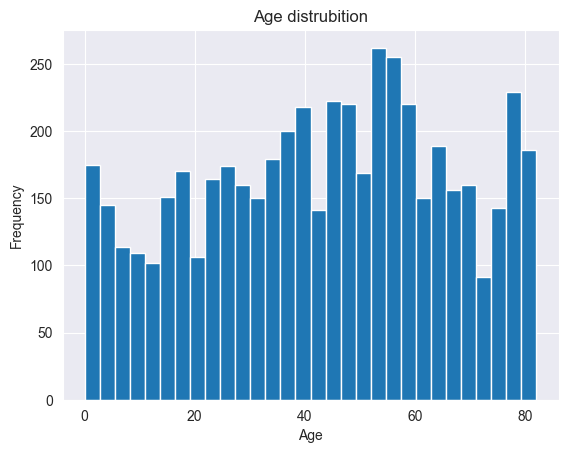

In [14]:
plt.hist(df['age'], bins=30)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age distrubition') 
plt.show()

# Age has a pretty even disturbition so we will have accurate findings.

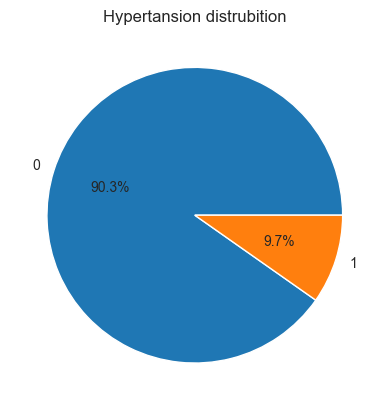

In [15]:
Hypertansion = df['hypertension'].value_counts()
plt.pie(Hypertansion.values, labels=Hypertansion.index, autopct='%1.1f%%') 
plt.title('Hypertansion distrubition') 
plt.show()

# 9.7% people out of 100 has hypertansion.

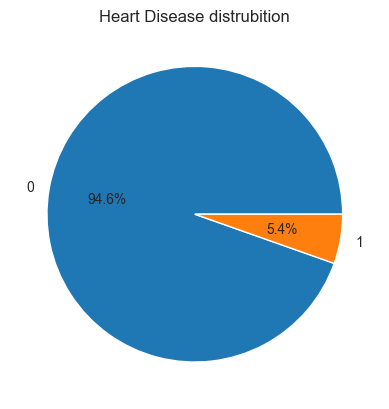

In [16]:
Heart_disease = df['heart_disease'].value_counts()
plt.pie(Heart_disease.values, labels=Heart_disease.index, autopct='%1.1f%%') 
plt.title('Heart Disease distrubition') 
plt.show()

# 5.4% people out of 100 has heart disease.
# Because it has a small percentage it could be hard to distunguish if it's effective on strokes.

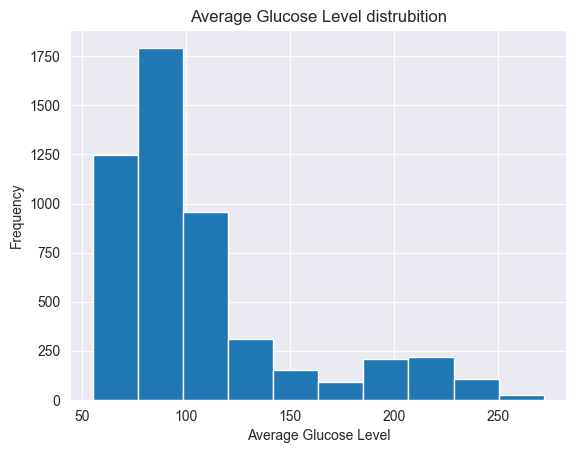

In [95]:
plt.hist(df['avg_glucose_level'], bins=10)
plt.xlabel('Average Glucose Level')
plt.ylabel('Frequency')
plt.title('Average Glucose Level distrubition') 
plt.show()
# I think I made a mistake when handling the outliers so there can't be seem any change. But I couldn't find my mistake.

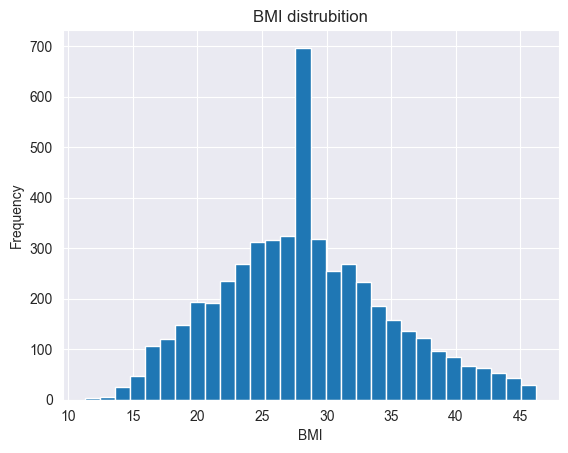

In [18]:
plt.hist(df['bmi'], bins=30)
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('BMI distrubition') 
plt.show()

# I think BMI disturbition is handled pretty good. And now it has a good disturbition.

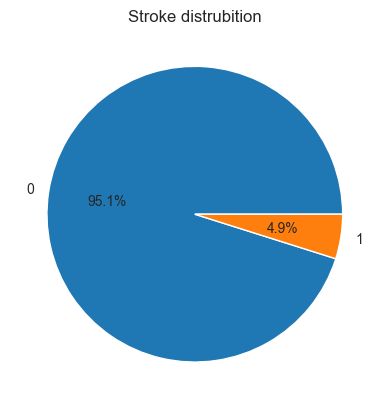

In [19]:
Stroke = df['stroke'].value_counts()
plt.pie(Stroke.values, labels=Stroke.index, autopct='%1.1f%%') 
plt.title('Stroke distrubition') 
plt.show()

# This disturbition shows that classes are unbalanced. And can cause a bias if it doesn't handled carefully in a classification problem.

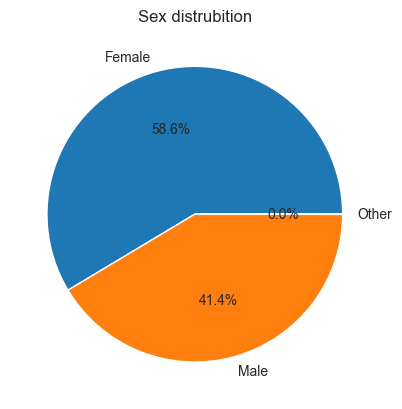

In [96]:
Gender = df['gender'].value_counts()
plt.pie(Gender.values, labels=Gender.index, autopct='%1.1f%%') 
plt.title('Sex distrubition') 
plt.show()

In [96]:
# The relationship between categorical features and the target variable.

pivot_table = df.pivot_table( 
    index= 'stroke',
    columns='gender',
    aggfunc= 'size'
)
pivot_table

# If we look at the distribution percentages, we can see that gender has no significant difference on the disturbition of "Stroke".

gender,Female,Male,Other
stroke,,,
0,2853.0,2007.0,1.0
1,141.0,108.0,NaN


In [97]:
pivot_table = df.pivot_table( 
    index= 'stroke',
    columns='ever_married',
    aggfunc= 'size'
)
pivot_table

# There seems to be correlation between Marriage and having Stroke. 
# And also we keep in mind that nearly 700 are childs. 
# 1000 people who doesn't married ever has a really low percantage respect to married ones.

ever_married,No,Yes
stroke,,
0,1728,3133
1,29,220


In [98]:
pivot_table = df.pivot_table( 
    index= 'stroke',
    columns='Residence_type',
    aggfunc= 'size'
)
pivot_table

# Living in Urban seems to be effective on not having a stroke even though it's correlation is so low. 

Residence_type,Rural,Urban
stroke,,
0,2400,2461
1,114,135


In [99]:
pivot_table = df.pivot_table( 
    index= 'stroke',
    columns='work_type',
    aggfunc= 'size'
)
pivot_table

# This table shows some important information about the effect of work types effect on having a stroke.
# People who has govermant job seems to have least stroke chance after childs.
# Then Private jobs correlation about stroke is less than self-employed people.
# For the never worked people, it can't be done so much comment cause we have so little data.

work_type,Govt_job,Never_worked,Private,Self-employed,children
stroke,,,,,
0,624.0,22.0,2776.0,754.0,685.0
1,33.0,NaN,149.0,65.0,2.0


In [100]:
pivot_table = df.pivot_table( 
    index= 'stroke',
    columns='smoking_status',
    aggfunc= 'size'
)
pivot_table

# Unknown percentage is pretty big and they seems to have less chance of having a stroke. We should try to find the reason why there is such a big percentange of unknown. Then we can make better comments about it.
# If we look with prejudge we except that smokers should be getting strokes more than the others.
# But it seems to be a interesting pattern: Former smokers are happens to be getting Strokes more than the ones smoking currently.


smoking_status,Unknown,formerly smoked,never smoked,smokes
stroke,,,,
0,1497,815,1802,747
1,47,70,90,42


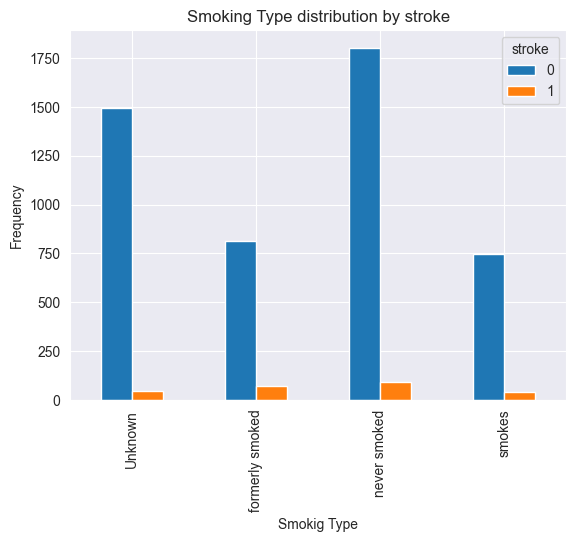

In [109]:
# I also wanted to see in a bar plot if it would help me realize smt new.
# But I couldn't take any more info than the ones in a pivot table.

Smoking_type = df.groupby(["smoking_status", "stroke"]).size().unstack(level=1).plot(kind='bar')

plt.xlabel('Smokig Type')
plt.ylabel('Frequency')
plt.title('Smoking Type distribution by stroke')
plt.show()

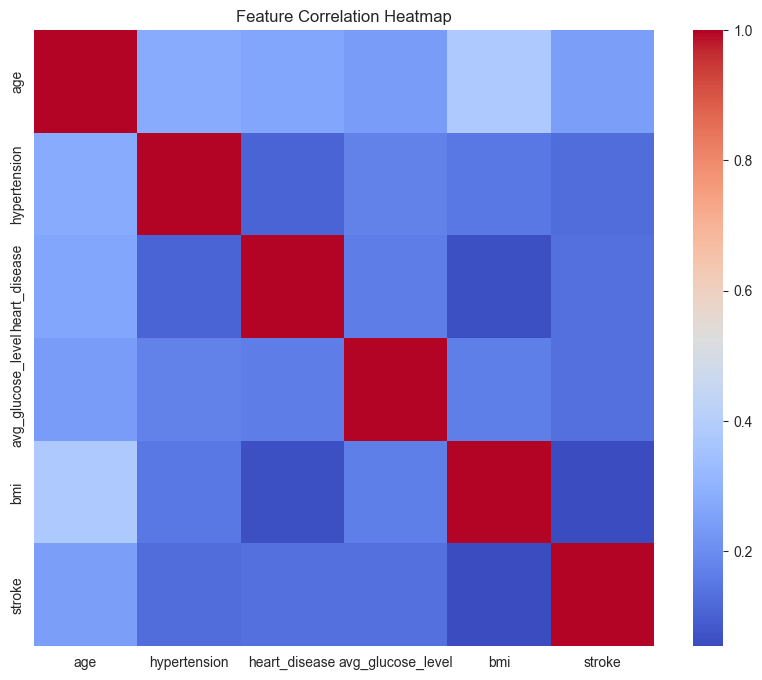

In [22]:
numeric_df = df.select_dtypes(include= ['float64', 'int64']).drop('id', axis=1)
correlation_matrix = numeric_df.corr() 

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, cmap= 'coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# The highest correlation seems to be between age and bmi.
# If we look at generally we can see that age has the highest correlation  with other variables naturally. That shows the normal nature of human being. As you get older your chance of being sick is getting higher and higher.
# Also for the stroke: it has a higher correlation with age, avg_glu_level, heart_disease and hypertansion. And bmi seems to have less effect on stroke.

## 1.3. Data Splitting (5 Pts)

* Manually split the dataset into training (70%) and testing (30%) sets
* Shuffle and split the data
* Avoid using predefined functions like train_test_split for this task


In [81]:
# Feature Selection:
# Gender, Age, Hypertension, Heart Disease, Ever Married, Work Type, Avg Glucose Level, and Smoking Status

categorical_columns = df.select_dtypes(include=['object']).drop('Residence_type', axis=1)

categorical_columns = categorical_columns.columns.tolist()
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Combine the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1).drop(['Residence_type', 'id', 'bmi'], axis=1)
print(f"Encoded Employee data : \n{df_encoded}")

Encoded Employee data : 
       age  hypertension  heart_disease  avg_glucose_level  stroke  \
0     67.0             0              1             228.69       1   
1     61.0             0              0             202.21       1   
2     80.0             0              1             105.92       1   
3     49.0             0              0             171.23       1   
4     79.0             1              0             174.12       1   
...    ...           ...            ...                ...     ...   
5105  80.0             1              0              83.75       0   
5106  81.0             0              0             125.20       0   
5107  35.0             0              0              82.99       0   
5108  51.0             0              0             166.29       0   
5109  44.0             0              0              85.28       0   

      gender_Female  gender_Male  gender_Other  ever_married_No  \
0               0.0          1.0           0.0              0.0   


In [33]:
# Data shuffling:
df_manual_shuffle = df_encoded.copy()

indices = list(range(len(df_manual_shuffle)))
random.seed(598)
random.shuffle(indices)

shuffled_data =[]
while indices:
    indexx = indices.pop()
    shuffled_data.append(df_manual_shuffle.iloc[indexx])
    
shuffled_df = pd.DataFrame(shuffled_data)

# split part
train_size = int(0.7 * len(shuffled_df))
train_df = shuffled_df.iloc[:train_size]
test_df = shuffled_df.iloc[train_size:]

X_train = train_df.drop('stroke', axis=1)
y_train = train_df['stroke']
X_test = test_df.drop('stroke', axis=1)
y_test = test_df['stroke']



# **PART- 2: Model Building (30 points)**

Implement two classification models:

* k-Nearest Neighbors (kNN)
* Logistic Regression


***You can use scikit-learn***




## 2.1. kNN Classifier (15 Pts)
* Build and train the kNN model
* Choose the optimal k value using Minkowski distance with at least two different values for p


In [60]:
knn = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9380300065231572


In [61]:
knn2 = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=2)
knn2.fit(X_train, y_train)

y_pred2 = knn2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print("Accuracy2:", accuracy2)

Accuracy2: 0.9406392694063926


In [62]:
knn3 = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=3)
knn3.fit(X_train, y_train)

y_pred3 = knn3.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred3)
print("Accuracy3:", accuracy3)

# I tried 3 different p and decided on 2 because it has highest accuracy. 
# Also I didn't want to rise it to 3 when it does not make a change.

Accuracy3: 0.9406392694063926


In [65]:
knn100k = KNeighborsClassifier(n_neighbors=100, metric='minkowski', p=2)
knn100k.fit(X_train, y_train)

y_pred100k = knn100k.predict(X_test)
accuracy100k = accuracy_score(y_test, y_pred100k)
print("Accuracy100k:", accuracy100k)


Accuracy100k: 0.9536855838225701


In [66]:
knn50k = KNeighborsClassifier(n_neighbors=50, metric='minkowski', p=2)
knn50k.fit(X_train, y_train)

y_pred50k = knn50k.predict(X_test)
accuracy50k = accuracy_score(y_test, y_pred50k)
print("Accuracy50k:", accuracy50k)

Accuracy50k: 0.9536855838225701


In [67]:
knn30k = KNeighborsClassifier(n_neighbors=30, metric='minkowski', p=2)
knn30k.fit(X_train, y_train)

y_pred30k = knn30k.predict(X_test)
accuracy30k = accuracy_score(y_test, y_pred30k)
print("Accuracy30k:", accuracy30k)

Accuracy30k: 0.9536855838225701


In [68]:
knn10k = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=2)
knn10k.fit(X_train, y_train)

y_pred10k = knn10k.predict(X_test)
accuracy10k = accuracy_score(y_test, y_pred10k)
print("Accuracy10k:", accuracy10k)

# I think this is the best out of the others I tried.
# I tried 5 different k and respect to accuracy this result seemed like the best until it starts giving same results again and again.

Accuracy10k: 0.9523809523809523


In [69]:
knn5k = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn5k.fit(X_train, y_train)

y_pred5k = knn5k.predict(X_test)
accuracy5k = accuracy_score(y_test, y_pred5k)
print("Accuracy5k:", accuracy5k)

Accuracy5k: 0.9452054794520548


## 2.2. Logistic Regression (15 Pts)
* Build and train the Logistic Regression model

In [97]:
log_reg = LogisticRegression(random_state= 41, max_iter=500)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)


# Checking Accuracy
accuracy = log_reg.score(X_test, y_test)
print("Logistiv Accuracy:", accuracy)

# In general my results seems to stuck in this accuracy. I know there is a problem but I am not sure about it. It could be cause of I forgat to normalize or standarize it. Also it has unbalanced class disturbition so it's a little bit hard to cath if it's overfitted or not.
# Also problem can be cause of overfitting so I will check it in the next part.

Logistiv Accuracy: 0.9536855838225701



# **PART- 3: Model Evaluation (35 points)**



## 3.1 Confusion Matrix (15)

Analysis of the confusion matrices for both models:

* Plot and interpret the confusion matrices
* Display accuracy, precision, recall, and F1-score for both models



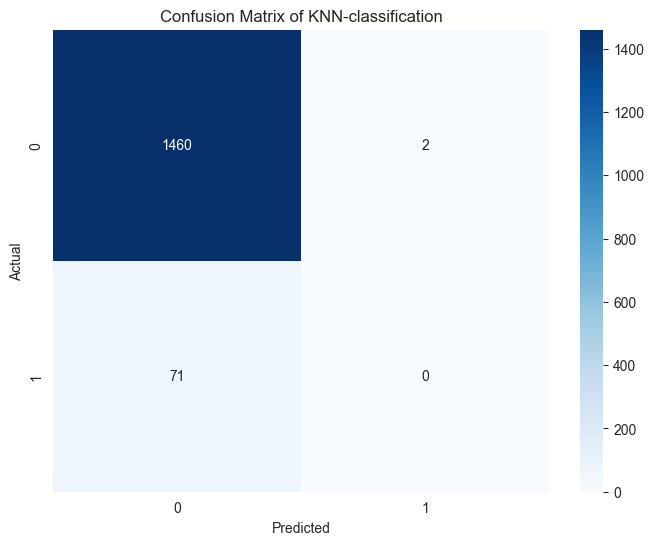

In [87]:
con_mat = confusion_matrix(y_test, y_pred10k)

plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of KNN-classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [89]:
TP = con_mat[1, 1]
TN = con_mat[0, 0]
FP = con_mat[0, 1]
FN = con_mat[1, 0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

# My model couldn't guessed any of the group '1'. That causes to have 0 prsicion and recall. That's a big problem. 

Accuracy: 0.9523809523809523
Precision: 0.0
Recall: 0.0
F1-Score: nan


C:\Users\Seyma\AppData\Local\Temp\ipykernel_37884\2411996818.py:9: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision * recall) / (precision + recall)


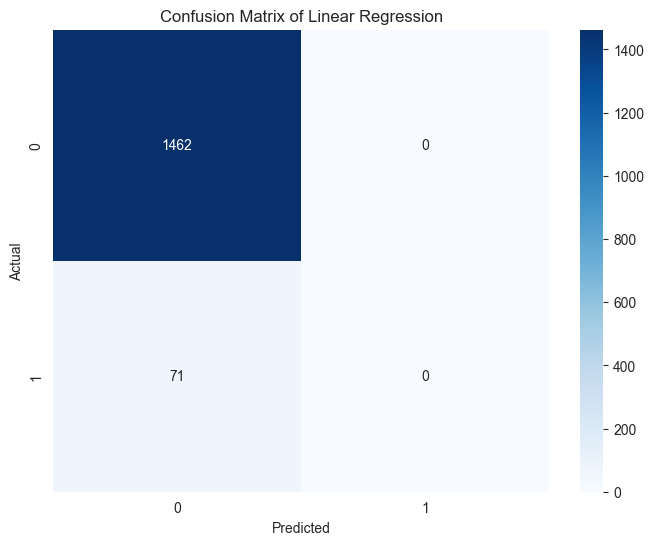

In [88]:
con_mat2 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(con_mat2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Linear Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [90]:
TP = con_mat2[1, 1]
TN = con_mat2[0, 0]
FP = con_mat2[0, 1]
FN = con_mat2[1, 0]

accuracy2 = (TP + TN) / (TP + TN + FP + FN)
precision2 = TP / (TP + FP)
recall2 = TP / (TP + FN)
f1_score2 = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy2)
print("Precision:", precision2)
print("Recall:", recall2)
print("F1-Score:", f1_score2)
# I think logistic regression just memorized it and overfitted.
# Because of big percentage is in the '0' class, it guesses every new value to there.

Accuracy: 0.9536855838225701
Precision: nan
Recall: 0.0
F1-Score: nan


C:\Users\Seyma\AppData\Local\Temp\ipykernel_37884\3710980303.py:7: RuntimeWarning: invalid value encountered in scalar divide
  precision2 = TP / (TP + FP)
C:\Users\Seyma\AppData\Local\Temp\ipykernel_37884\3710980303.py:9: RuntimeWarning: invalid value encountered in scalar divide
  f1_score2 = 2 * (precision * recall) / (precision + recall)


## 3.2 Precision-Recall Curves (5)

Evaluate the Precision-Recall curves for both models:

* Plot and analyze the curves

In [ ]:
# Because of my results I couldn't pass to this stage.

## 3.3. Compare the Model (15 Pts)

Prepare a detailed evaluation report with metrics, visualizations, and comparative analysis.

* Compare the performance of kNN and Logistic Regression based on the metrics.

* Discuss which model performs better and hypothesize why.

In [ ]:
# In my implementations KNN showed a better result. Cause it at least guessed from the '0' class even though it was wrong. 
# My logistic regression just memorized it and that causes me to not being able to compare them properly. But I liked KNN classification better.

# SUBMIT FORMAT

* **<-zip>**
  - **studentID_name_surname_hw4.ipynb**


# PLAGIARISM

All work on assignments must be done individually. You are encouraged to discuss the given assignments with your classmates, but these discussions should be carried out in an abstract way. That is, discussions related to a particular solution to a specific probem (either in actual code or in pseudocode) will not be tolerated. In short, turning in someone else’s work (including work available on the internet), in whole or in part, as your own will be considered as a violation of academic integrity. Please note that the former conditions also hold for the material attained using AI tools, including ChatGPT, GitHub Copilot, etc.